In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import os 
import sys
local_path = os.path.abspath('')
sys.path.append(local_path)
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
from functions import plotgenerator as pg
import utils, model, egm, simulations, estimation 

## See how input input data is interpolated

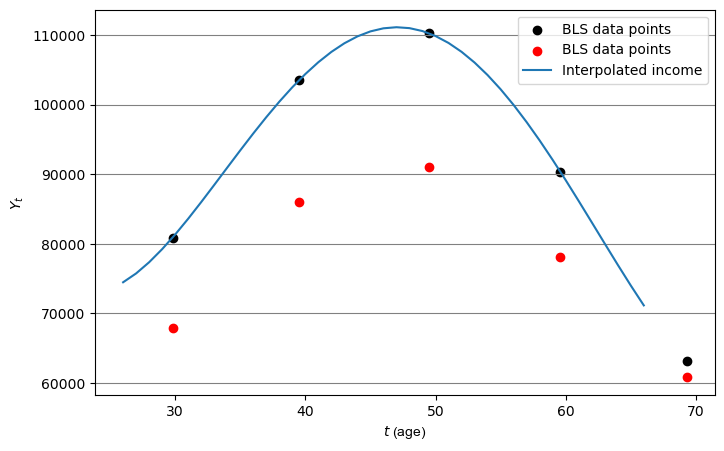

In [3]:
# Setup
par_data = model.gp_model()#**{'sigma_mu':0,'sigma_eta':0,'pi':0})
# par_data.par.init_P = 1
# Solve the model
solObj = egm.solver(par_data.par)
solObj.solve(do_print=False)
sol = solObj.sol
sim_data = simulations.Simulator(par_data.par, sol)
sim_data = sim_data.main()

fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
# fig.add_plot(x=par_data.grid_age[:-1],y=sim_data.Y_avg,marker='o',color='grey',label='Model prediction of Y')
fig.add_plot(x=list(par_data.income_data.keys()),y=list(par_data.income_data.values()),marker='o',color='black',label='BLS data points')
fig.add_plot(x=list(par_data.consumption_data.keys()),y=list(par_data.consumption_data.values()),marker='o',color='red',label='BLS data points')
fig.add_plot(x=par_data.grid_age,y=par_data.Ybar,linestyle='-',label='Interpolated income')
fig.set_ylabel(f"$Y_t$")
fig.set_xlabel(f"$t$ (age)")
fig.add_gridlines(axis='y')
fig.add_legend()
# fig.save_figure(f'{local_path}/output/income_data.png')
fig.show()

### plotting Income shifter

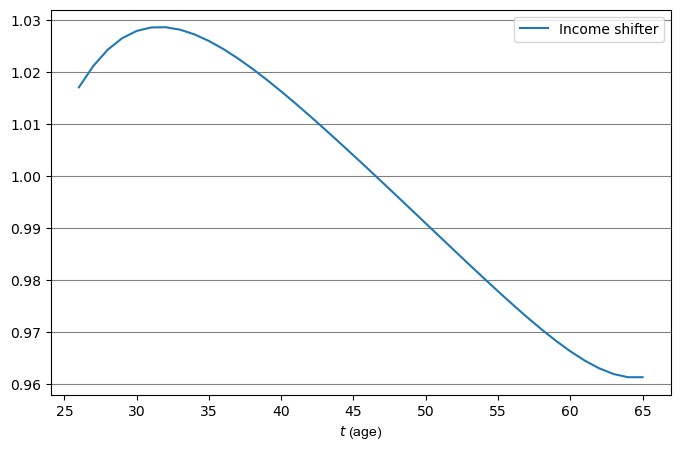

In [4]:
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')

# fig.add_plot(par_data.grid_age[:-1],sim_data.Y_avg, label=f"Income", linestyle='-',axis='y1')
# fig.add_plot(par_data.grid_age[:-1],sim_data.C_avg, label=f"Consumption", linestyle='-',axis='y1')
fig.add_plot(par_data.grid_age[:-1],par_data.par.G, label=f"Income shifter", linestyle='-',axis='y1')
# fig.set_ylabel(f"$G_t$",axis='y2')
fig.set_xlabel(f"$t$ (age)")
fig.add_legend()
fig.add_gridlines(axis='y')
# fig.save_figure(f'{local_path}/output/income_shifter.png')
fig.show()

# Solution to the model

In [5]:
# Setup
par_init_sol = model.gp_model()

# Solve the model
solObj = egm.solver(par_init_sol.par)
solObj.solve(do_print=False)
sol = solObj.sol

### plotting the results

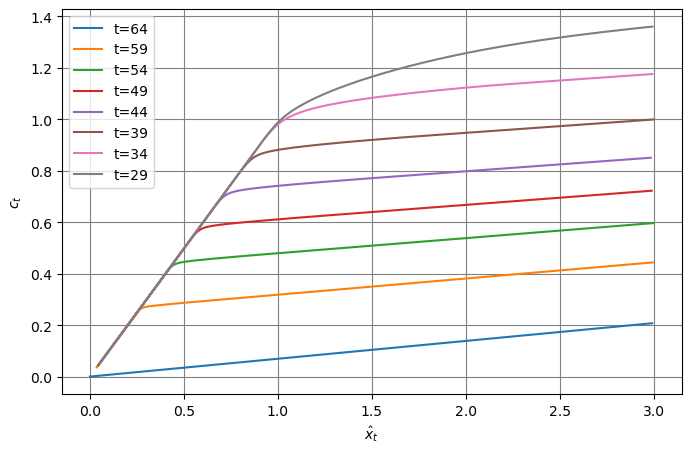

In [6]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
for t in range(par_init_sol.par.Tr_N-1,par_init_sol.par.t0_N-1,-5):
    criteria = np.where(sol.m[:,t] <= 3, True, False)
    fig.add_plot(sol.m[criteria,t],sol.c[criteria,t], label=f"t={25+t}", linestyle='-')
fig.set_ylabel(f"$c_t$")
fig.set_xlabel("$\hat{x}_t$")
fig.add_gridlines(axis='both')
fig.add_legend()
#fig.save_figure(f'{local_path}/output/egm_consumption.png')
fig.show()

### simulate how results look like

(40,)


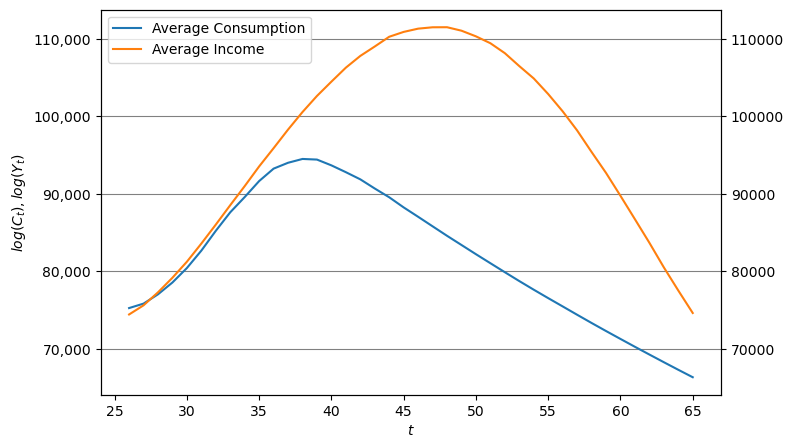

In [7]:
sim = simulations.Simulator(par_init_sol.par, sol)
sim = sim.main()
# Plot simulation of the solution
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr)
print(sim.C_avg.shape)
fig.add_plot(x,sim.C_avg, label=f"Average Consumption", linestyle='-',axis='y1')
fig.add_plot(x,sim.Y_avg, label=f"Average Income", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$log(C_t), log(Y_t)$")
fig.set_xlabel(f"$t$")
fig.set_number_format('y','{x:,.0f}')
fig.add_gridlines(axis='y')
fig.add_legend()
# fig.save_figure(f'{local_path}/output/simulation_of_solution.png')
fig.show()

##### Decompose savings 

In [8]:
model_lc = model.gp_model(**{'sigma_eta': 0.0, 'sigma_mu':0.0,'pi':0,'xmin':-10.0})

# retirement rule
NT = 88-65
beta = 1.0/(1.0344) # estimated in GP
beta_rho = beta**(1.0/model_lc.par.rho)
R_rho = (1+model_lc.par.R)**(1.0/model_lc.par.rho - 1.0)
nom = 1.0 - beta_rho*R_rho
denom = 1.0 - (beta_rho*R_rho)**NT
model_lc.gamma1 = nom/denom
model_lc.main_setup()

# Solve the Life-cycle model
sol_lc = egm.solver(model_lc.par)
sol_lc.solve(do_print=False)
sol_lc = sol_lc.sol

# Simulate the Life-cycle model
sim_lc = simulations.Simulator(model_lc.par, sol_lc)
sim_lc = sim_lc.main()

In [9]:
# Decomposition
S_lc = np.mean(sim_lc.S[1:],axis=1)
S = np.mean(sim.S[1:],axis=1)
S_b  = S - S_lc 

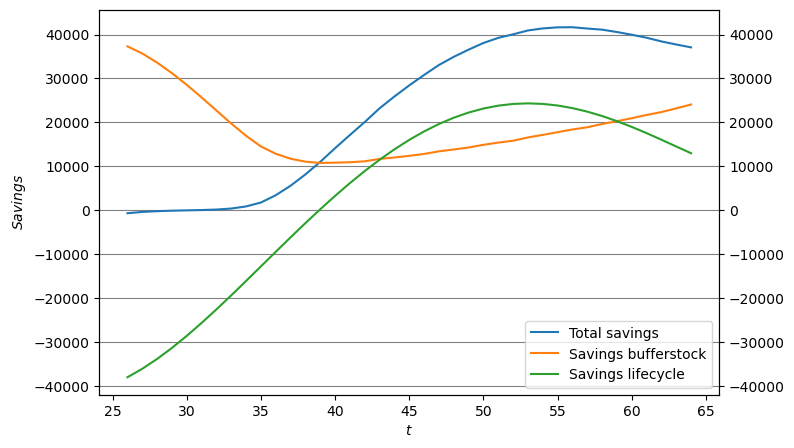

In [10]:
# Print consumption function
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(0+par_init_sol.par.t0,len(S)+par_init_sol.par.t0)
fig.add_plot(x,S, label=f"Total savings", linestyle='-',axis='y1')
fig.add_plot(x,S_b, label=f"Savings bufferstock", linestyle='-',axis='y1')
fig.add_plot(x,S_lc, label=f"Savings lifecycle", linestyle='-',axis='y1')
fig._set_scaling()
fig.set_ylabel(f"$Savings$")
fig.set_xlabel(f"$t$")
fig.add_gridlines(axis='y')
fig.add_legend()
# fig.save_figure(f'{local_path}/output/savings_decomposition.png')
fig.show()


# Estimation based on random data

### Data generation

In [11]:
# Setup params
par_dgp = model.gp_model().par
par_dgp.beta = 0.95
par_dgp.rho = 0.45
sol_dgp = egm.solver(par_dgp)
sol_dgp.solve(do_print=False)

dgp_par = [par_dgp.beta, par_dgp.rho]
# 
sim_dgp = simulations.Simulator(par_dgp, sol_dgp.sol)
sim_dgp = sim_dgp.main()
input_data = np.log(sim_dgp.C_avg)


In [12]:
weight_mat_inv =  np.eye(input_data.size)   # The identity matrix and I^-1=I #np.diag(sim_dgp.C_var)
est = estimation.SMD(model=par_dgp,solver=egm.solver, simulator=simulations.Simulator, mom_data=input_data)

### grid search - and plot the objective function for different values

In [13]:
est.beta_grid = np.arange(0.9,0.96,0.01)
est.rho_grid = np.arange(0.45,0.5,0.01)
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

### estimation

In [14]:
est.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=None,W=weight_mat_inv, grid=False)

In [15]:
print(f'estimated values using grid method {est.est} and true parameters {dgp_par}')
print(est.obj_function([est.est[0],est.est[1]],['beta','rho'],W=weight_mat_inv))

estimated values using grid method [0.95000155 0.44995906] and true parameters [0.95, 0.45]
8.908174539122135e-12


In [16]:
# Obtain the variance-covariance matrix
var_cov_matrix = est.estimate_variance_covariance_matrix(est.est, ['beta','rho'], W=weight_mat_inv)
print(var_cov_matrix)

[[-3.53440425e+22  1.47908427e+24]
 [ 1.47908427e+24 -6.18970020e+25]]


# Estimation using data from BLS
For data look at the very top

In [17]:
# Setup
model_real = model.gp_model()
par_real = model_real.par

# input the data
real_data = model_real.Cbar[:-1]
print(real_data,'\n',len(real_data))

[11.01642596 11.04363347 11.07229142 11.10175865 11.13148258 11.16099417
 11.18990037 11.21787548 11.24465222 11.27001324 11.29378326 11.31582205
 11.33601836 11.35428469 11.37055293 11.38477067 11.39689822 11.40690622
 11.41477369 11.42048657 11.42403666 11.42542086 11.42464079 11.4217027
 11.41661763 11.40940201 11.40007841 11.38867681 11.37523612 11.35980622
 11.3424505  11.32324883 11.30230136 11.27973281 11.25569765 11.23038597
 11.20403015 11.1769122  11.14937147 11.12181246] 
 40


In [18]:
weight_mat_inv = np.eye(real_data.size)   # The identity matrix and I^-1=I
est_real = estimation.SMD(model=par_real,solver=egm.solver, simulator=simulations.Simulator, mom_data=real_data)
est_real.age_groups = False

In [19]:
est_real.beta_grid = np.arange(0.50,0.99,0.03)
est_real.rho_grid = np.arange(0.01,0.99,0.05)
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv,grid=True)

/Users/asbjornfyhn/Desktop/Dyn Prog/DP-life-cycle/simulations.py:78: RuntimeWarning: divide by zero encountered in log
  self.sim.C_avg[t] = np.exp(np.mean(np.log(self.sim.C[t,I]))) # use to be exp(mean(log(C))) ???
/Users/asbjornfyhn/Desktop/Dyn Prog/DP-life-cycle/estimation.py:13: RuntimeWarning: divide by zero encountered in log
  return np.log(data.C_avg)
/Users/asbjornfyhn/Desktop/Dyn Prog/DP-life-cycle/estimation.py:41: RuntimeWarning: invalid value encountered in matmul
  self.obj  = (np.transpose(self.diff) @ W) @ self.diff


In [20]:
if hasattr(est_real,'grid'):
  fig = make_subplots(
      rows=1, 
      cols=2,
      start_cell="top-left", 
      specs=[
          [{"type": "surface"}, {"type": "scattergl"}], 
      ]
  )
  fig.update_layout(paper_bgcolor="rgba(0,0,0,0)",plot_bgcolor="grey",font=dict(family="Arial",size=12,color="white"))
  # Sample data
  x, y = np.meshgrid(est_real.beta_grid, est_real.rho_grid)
  z = est_real.grid

  # Create the surface plot
  # fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])
  fig.add_trace(go.Surface(z=z, x=x, y=y, #coloraxis=dict(coloraxis=1),
                           ),row=1,col=1)

  # Update axes titles for the mesh plot
  fig.update_scenes(
      xaxis_title='Beta',
      yaxis_title='Rho',
      zaxis_title='Objective function',
      row=1, col=1
  )
  fig.update_scenes(aspectratio=dict(x=1, y=1, z=0.7),
                     row=1, col=1)

  fig.update_layout(title='Objective function', autosize=False,width=1000, height=500,margin=dict(l=65, r=50, b=65, t=90))
  # set the background color
  y = est_real.grid[3,:]
  x = est_real.rho_grid

  # fig = go.Figure()
  fig.add_trace(go.Scatter(x=x, y=y, mode='lines', ),row=1,col=2)
  # Update axes titles for each subplot
  fig.update_xaxes(title_text=f'rho', row=1, col=2)
  fig.update_yaxes(title_text='Objective function', 
                   row=1, col=2)

  fig.show()
else:
  print('No grid found')

In [29]:
est_real.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],bounds=[(0.01,1.05),(0.01,0.999)],W=weight_mat_inv,grid=False)

In [30]:
print(est_real.est_out.success)
print(f'estimated values {est_real.est} with objective function value {est_real.est_out.fun}')

True
estimated values [0.9638136 0.999    ] with objective function value 0.38370101392183487


In [31]:
# Setup
rho_opt = est_real.est[1]
beta_opt = est_real.est[0]
print(f'Optimal beta: {beta_opt}, Optimal rho: {rho_opt}')
par_fit = model.gp_model(**{'beta':beta_opt,'rho':rho_opt}).par
# solve model
solObjfit = egm.solver(par_fit)
solObjfit.solve()
sol_fit = solObjfit.sol

# 
sim_fit = simulations.Simulator(par_fit, sol_fit)
sim_fit = sim_fit.main()

Optimal beta: 0.9638135981711957, Optimal rho: 0.999


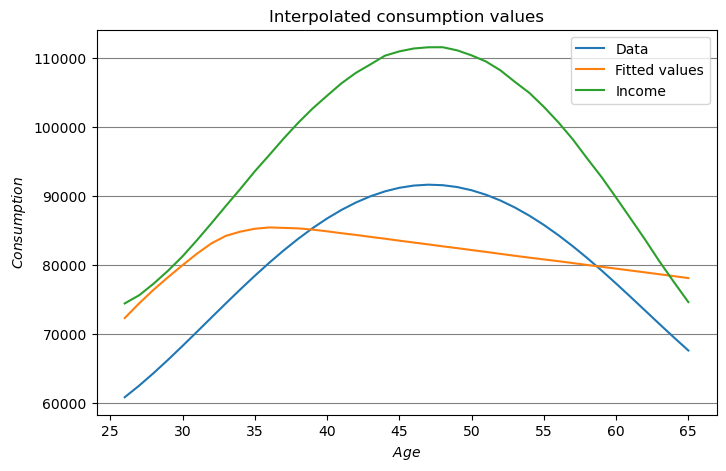

In [32]:
# plot the interpolated values
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')

# fig.add_plot(model_real.grid_age[:-1], np.exp(model_real.Ybar[:-1]), label=f"Data", linestyle='-')
fig.add_plot(model_real.grid_age[:-1], np.exp(model_real.Cbar[:-1]), label=f"Data", linestyle='-')
fig.add_plot(model_real.grid_age[:-1], (sim_fit.C_avg), label=f"Fitted values", linestyle='-')
fig.add_plot(model_real.grid_age[:-1], (sim_fit.Y_avg), label=f"Income", linestyle='-')
fig.set_ylabel(f"$Consumption$")
fig.set_xlabel(f"$Age$")
fig.set_title(f'Interpolated consumption values')
fig.add_gridlines(axis='y')
fig.add_legend()
fig.show()

# Extension
Imagine two types of households with different timepreference, $\beta$

#### Type I

In [ ]:
# Setup params
par_type1 = model.gp_model().par
par_type1.beta = 0.99
sol_type1 = egm.solver(par_type1)
sol_type1.solve()
sol_type1 = sol_type1.sol

type1_par = [par_type1.beta, par_type1.rho]
# 
sim_type1 = simulations.Simulator(par_type1, sol_type1).sim

#### Type II

In [ ]:
# Setup params
par_type2 = model.gp_model().par
par_type2.beta = 0.90
sol_type2 = egm.solver(par_type2)
sol_type2.solve()
sol_type2 = sol_type2.sol

type2_par = [par_type2.beta, par_type2.rho]

sim_type2 = simulations.Simulator(par_type2, sol_type2).sim

#### Aggregate consumption
Denoting the share of type I households as $\lambda$, the aggregate consumption is given by:
$$
C^{agg}_t = \lambda C^I_t + (1-\lambda) C^{II}_t
$$

In [ ]:
lambda1 = 0.4
lambda2 = 1 - lambda1
agg_model = model.gp_model().par
agg_cons = lambda1*sim_type1.C_avg + lambda2 * sim_type2.C_avg

In [ ]:
# plot consumption
fig = pg.PlotFigure(figsize=(8,5),fontname='Arial')
x = range(par_init_sol.par.t0,par_init_sol.par.Tr)
fig.add_plot(x,agg_cons, label=f"Aggregate", linestyle='-',axis='y1')
fig.add_plot(x,sim_type1.C_avg, label=f"Type I", linestyle='-',axis='y1')
fig.add_plot(x,sim_type2.C_avg, label=f"Type II", linestyle='-',axis='y1')
fig.add_gridlines(axis='y')
fig.set_ylabel(f"$C_t$")
fig.set_xlabel(f"$t$")
fig.set_title(f'Consumption over life-cycle for different types')
fig.add_legend()
fig.show()


In [ ]:
weight_mat_inv = np.eye(agg_cons.shape[0])   # The identity matrix and I^-1=I
est_ext = estimation.SMD(model=agg_model,solver=egm.solver, simulator=simulations.Simulator, mom_data=agg_cons)

In [ ]:
est_ext.beta_grid = np.arange(0.9,0.99,0.01)
est_ext.rho_grid = np.arange(0.4,0.5,0.01)
est_ext.estimate(theta0=[0.9,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=True)

In [ ]:
# Sample data
x, y = np.meshgrid(np.arange(0.9,1,0.01), np.arange(0.9,1,0.01))
z = est_ext.grid

# Create the surface plot
fig = go.Figure(data=[go.Surface(z=z, x=x, y=y)])

# Update layout
fig.update_layout(title='Objective function', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90),
                scene=dict(xaxis=dict(title='beta'),
                    yaxis=dict(title='rho')))

# Show the figure
fig.show()
print(f'estimated values using grid method {est_ext.est} ')

In [ ]:
est_ext.estimate(theta0=[0.97,0.4],est_par=['beta','rho'],W=weight_mat_inv, grid=False)

In [ ]:
if est_ext.est_out.success:
    print(f'estimated values using scipy optimizer {est_ext.est}')
else:
    print(f'optimization failed')